[View in Colaboratory](https://colab.research.google.com/github/Milite/Data-Scinece/blob/master/686_Project_Seedlings_Meng_Luo_First%20submission_0.443.ipynb)

# MSDS686 Project - Plant Seedlings Classification  V0.5
The porject is provided by Kaggle [https://www.kaggle.com/c/plant-seedlings-classification]

## Introduction
The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has recently released a dataset containing images of approximately 960 unique plants belonging to 12 species at several growth stages. The goal of the competition is to create a classifier capable of determining a plant's species from a photo. And we will build CNN models to predict the type of the plants.

In [0]:
## Global varibles
dataset_path = "drive/My Drive/Colab Notebooks/Kaggle Data/Plant Seedlings Classification"
splitno_path = 4   # How many '/' exists in the dataset path
reduce_scale = 128 # Train with images resized to this many pixels. Used value: 64
#-- reduce_frac  = 0.5 # Train with this fraction of data first to be efficient. Used value: 0.1, 0.5 #Oct 11
#-- aug_ratio    = 2.5 # Aim to have 10000 pictures
seed         = 42  # Set random seed
batch_size   = 50
epoch        = 30


In [3]:
## Loading in Data using google drive
#REFERENCE https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q#scrollTo=H4SJ-tGNkOeY
# Originally posted in discussion board by Kat. https://worldclass.regis.edu/d2l/le/224600/discussions/threads/1339444/View 
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
## Load models
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import math
import random
import os
import glob

from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Activation

from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from keras.layers.advanced_activations import PReLU
#class PRELU(PReLU):
#    def __init__(self, **kwargs):
#        self.__name__ = "PRELU"
#        super(PRELU, self).__init__(**kwargs)



Using TensorFlow backend.


In [23]:
### Create dataset 
## REFERENCE: https://www.kaggle.com/vanausloos/how-to-read-images-in-python; https://www.kaggle.com/nikkonst/plant-seedlings-with-cnn-and-image-processing
train_path=dataset_path+"/train"
labels = os.listdir(train_path)
classno = len(labels) #12 classes 
encode_map={'Black-grass': 3,
 'Charlock': 5,
 'Cleavers': 4,
 'Common Chickweed': 7,
 'Common wheat': 1,
 'Fat Hen': 2,
 'Loose Silky-bent': 8,
 'Maize': 6,
 'Scentless Mayweed': 9,
 'Shepherds Purse': 10,
 'Small-flowered Cranesbill': 11,
 'Sugar beet': 12}
#encode_map ={k: v for k, v in zip(labels,list(range(1,classno+1)))}
train_files = glob.glob(train_path+'/*/*.png')
train_labels = [f.split('/')[splitno_path+2] for f in train_files]

## Loading images
train_im = []
j=0
for im in train_files:
    print(j+1)
    train_im.append(cv2.resize(cv2.imread(im), (reduce_scale, reduce_scale)))  # Get image (with resizing)
    j += 1


{'Black-grass': 3,
 'Charlock': 5,
 'Cleavers': 4,
 'Common Chickweed': 7,
 'Common wheat': 1,
 'Fat Hen': 2,
 'Loose Silky-bent': 8,
 'Maize': 6,
 'Scentless Mayweed': 9,
 'Shepherds Purse': 10,
 'Small-flowered Cranesbill': 11,
 'Sugar beet': 12}

### Explortary Data Analysis
Check the size of the training data and whether it is imbalanced. It turns out acceptable (221~654 images). We should consider data augmentation since this is a small dataset.

In [0]:
len(train_files) # 4750 photos in the training set.
sns.countplot(train_labels); 

(128, 128, 3)

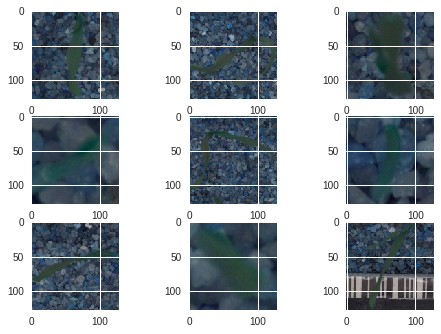

In [7]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_im[i]) #Looking good

train_im[21].shape

### Create checkpoints for later callbacks

In [0]:

filepath="weights_best-{epoch:02d}_{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')    

filepath='weights_last_auto.hdf5'
checkpoints_all = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

callbacks_list = [checkpoint, checkpoints_all] 

In [0]:
###  Saving files and weights
## REFERENCE Kat mentioned in the discussion board. original from http://www.astrobetter.com/blog/2013/07/29/python-tip-storing-data/ 
np.save('train_im', train_im)
np.save('test_im', test_im)
np.save('train_im_masked', train_im_masked)
np.save('train_labels', train_labels)

### Image processing


1. Should we use mask or greyscale? See discussion board. I chose to use only mask here.  
2. Create and normalize datasets, including encoding categorical labels with one-hot approach.   
3. Data augmentation is necessary it time allows to increase the training data size.



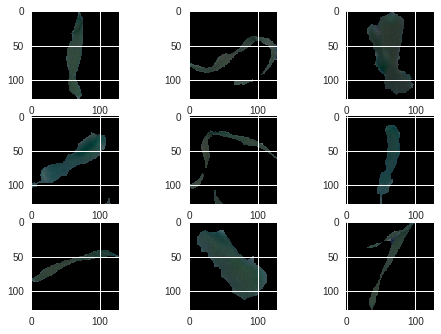

In [9]:
### 1. Create a mask for green areas
### REFERENCE: 
train_im_masked = [];
for i in train_im:
    blurr = cv2.GaussianBlur(i,(5,5),0) # Use gaussian blur
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV) # Convert to HSV image
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8) # Create empty image
    new[boolean] = i[boolean] # Apply boolean mask to the origin image
    train_im_masked.append(new) # Append the image without background
      
for i in range(9): # Check the results
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_im_masked[i])

In [0]:
### 2. Create datasets
train_masked_df = pd.DataFrame({'im':train_im_masked,'label':train_labels})  
train_masked_df.label=train_masked_df.label.replace(encode_map)-1  
X_train = np.array(train_im_masked).astype( 'float32' )/255 # Normalization
Y_train = to_categorical(train_masked_df.label) #onehot encoding

In [0]:
### 3. Data augmentation
### REFERENCE: https://chtseng.wordpress.com/2018/01/19/kaggle-%E7%99%BC%E8%8A%BD%E6%A4%8D%E7%89%A9%E5%88%86%E9%A1%9E/
### not useful
datagen = ImageDataGenerator(
    zoom_range = 0.2,
    shear_range=0.5,
    rotation_range = 40) 
train_generator = datagen.flow(X_train, Y_train, batch_size=batch_size)
val_generator = datagen.flow(X_val, Y_val, batch_size=batch_size)

### Models

1. Simple CNN
2. Deep CNN model with 3 units
3. Model with pretrained weights.

In [12]:
### 2. Deep CNN model with units
### REFERENCE: MSDS686 MNIST assignment solution by Dr Geena Kim  (Oct 11)
def unit(model, n_filter=32, init=False):
    """
    The basic unit is conv-batchnorm-conv-maxpool-batchnorm-dropout
    """
    if init:
        model.add(Conv2D(32,2,activation='relu',input_shape=(reduce_scale,reduce_scale,3),padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(64,2,activation='relu',padding='same'))
    else:   
        model.add(Conv2D(n_filter,2,activation='relu',padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(n_filter,2,activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3)) #Not using the default 0.5 because I am using BatchNormalization.  
    return model

def model2_deep_cnn(n):
    model=Sequential()
    model = unit(model,init=True)
    if n>1:
        for i in range(1, n):
            model=unit(model,n_filter=64)       
    model.add(Flatten())
    model.add(Dense(32, activation= 'relu'))
    model.add(Dense(classno, activation= 'softmax')) 
    return model

model2 = model2_deep_cnn(n=3)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      416       
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 64)      8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        16448     
__________

In [0]:
### Train Model2
lr = 0.0002 #0.0001, 0.002 not right...
decay = lr/epoch
model2.compile(loss= 'binary_crossentropy', optimizer= keras.optimizers.adam(lr=lr,decay=decay), metrics=['accuracy'])
#hist_train = model2.fit_generator(train_generator, steps_per_epoch=50, epochs=epoch, X_val, validation_steps=10, callbacks=callbacks_list)   
hist_train = model2.fit(X_train, Y_train, epochs=epoch, validation_split=0.2, callbacks=callbacks_list, batch_size=batch_size)  

In [26]:
### Plot out Model 2
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train history for Model 2')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    legendLoc = 'lower right' if(train=='acc') else 'upper right'
    plt.legend(['train', 'validation'], loc=legendLoc)
    plt.show()

show_train_history(hist_train, 'acc', 'val_acc')

hist_train.history


{'acc': [0.9990350894237819,
  0.9994298274579801,
  0.9994078960857893,
  0.9998026317671725,
  0.9996929835332068,
  0.9995175474568417,
  0.9996929858860216,
  0.9997807035320684,
  0.9998026325514442,
  0.9998026309829009,
  0.999868421178115,
  0.9997368439247734,
  0.9998464921587392,
  0.9999122807854101,
  0.9998464921587392,
  0.9999122807854101,
  0.999627192553721,
  0.9996491223573685,
  0.9999122807854101,
  0.9998245631393633,
  0.9996491254944551,
  0.9996491247101834,
  0.9998684219623867,
  0.9998903517660341,
  0.9995833345149693,
  0.9997368439247734,
  0.99982456157082,
  0.9998684219623867,
  0.9996929835332068,
  0.999868421178115],
 'loss': [0.004799865136623052,
  0.002774792644470979,
  0.0026837143691648777,
  0.0019327979902491758,
  0.0018891947758292143,
  0.0023692650519430906,
  0.0017593686279724352,
  0.0013984562358114328,
  0.0012746824974639917,
  0.001216077689748904,
  0.0010271491859097487,
  0.0012936901482470077,
  0.001065459054332582,
  0.0009

In [0]:
show_train_history(hist_train, 'loss', 'val_loss')

In [0]:
###Process the test dataset
test_path = dataset_path+"/test"
test_files = glob.glob(test_path+'/*.png')
test_names = [f.split('/')[splitno_path+2] for f in test_files]

test_im=[]; j=0
for im in test_files:
    print(j+1)
    test_im.append(cv2.resize(cv2.imread(im), (reduce_scale, reduce_scale)))  # Get image (with resizing)
    j += 1
    
test_im_masked = [];
for i in test_im:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8) 
    new[boolean] = i[boolean] 
    test_im_masked.append(new) 

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_im_masked[i]) #Looking good
    
X_test = np.array(test_im_masked).astype('float32')/255 # Normalization

X_test.shape

In [0]:
bestmodel=keras.models.load_model('weights_best-01_0.8706.hdf5')
Y_test = bestmodel.predict_classes(X_test)
Y_test 

Y_test = Y_test +1
inv_map= {v : k for k, v in encode_map.items()}

y_test = [];i=0
for file in test_names:
    y_test.append(inv_map[Y_test[i]])
    i+=1
submission = pd.DataFrame({'file': test_names, 'species': y_test})

### Submission
submission.to_csv('submission.csv', index=False)


